In [33]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np


In [34]:
import numpy as np


def pressure_theoretical(r, R, LAMBDA):

    if LAMBDA == 0:
        return (R**2 - r**2)/4

    """
    Analytical solution for radial stress (Weady et al. 2024).
    """
    c = (np.sqrt(1 + LAMBDA * R**2 / 2) - 1) / (2 * LAMBDA * R**2)
    return np.maximum(2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2), 0)


def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def compute_packing_fraction(shell_particles, r_inner, r_outer, mode="soft"):
    """
    Compute packing fraction of particles inside a radial shell.

    Args:
        shell_particles: DataFrame of particles within the shell
        r_inner: inner radius of the shell
        r_outer: outer radius of the shell
        mode: 'soft' or 'hard' (determines which length column to use)

    Returns:
        Packing fraction (float)
    """
    if len(shell_particles) == 0:
        return 0.0

    # Total particle area
    total_particle_area = sum(spherocylinder_area(length)
                              for length in shell_particles["length"])

    # Shell area
    shell_area = np.pi * (r_outer**2 - r_inner**2)

    return total_particle_area / shell_area

In [35]:
# Define colors for modes
MODE_COLORS = {"Hard": "blue", "Soft": "orange"}
LINE_STYLES = ["-", "--", "-.", ":"]  # cycle for different exponents
SYMBOLS = ["o", "s", "^", "D"]  # cycle for different exponents
SYMBOL_COLORS = ["blue", "orange", "green", "red", "purple", "brown"]


def get_style(mode, exp):
    """
    Returns (color, linestyle) based on sim_dir.
    Hard = blue, Soft = red.
    linestyle determined by exponent.
    """

    # cycle if more than 4 exponents

    linestyle = LINE_STYLES[(-exp) % len(LINE_STYLES)]
    symbol = SYMBOLS[(-exp) % len(SYMBOLS)]
    symbol_color = SYMBOL_COLORS[(-exp) % len(SYMBOL_COLORS)]

    return MODE_COLORS[mode], linestyle, symbol, symbol_color


def plot_radial_distribution(particles_dict, variable, bin_size=2.0, outname=None, plot_theory=False):
    """
    Plot radial distribution for multiple simulations.
    Can optionally overlay the theoretical solution for stress.
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = outname or f"combined_radial_{variable}.png"

    theoreticals = {}

    for (mode, exp, label), df in particles_dict.items():
        color, linestyle, symbol, symbol_color = get_style(mode, exp)
        df = df.copy()
        df["dist_center"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
        max_radius = int(df["dist_center"].max())

        r_edges = np.arange(0, max_radius + bin_size, bin_size)
        r_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

        vals = []
        for i in range(len(r_centers)):
            mask = (df["dist_center"] >= r_edges[i]) & (
                df["dist_center"] < r_edges[i+1])
            shell = df[mask]
            if variable == "packing_fraction":
                length_col = [c for c in df.columns if "length" in c][0]
                val = compute_packing_fraction(
                    shell, r_edges[i], r_edges[i+1], length_col)
            else:
                val = shell[variable].mean() if len(shell) else 0
            vals.append(val)

        # ax.plot(r_centers, vals, color=color, linestyle=linestyle, label=label)
        ax.plot(r_centers, vals, symbol, ls=linestyle, color=color,
                linewidth=2, ms=10, mfc=symbol_color, mec='black', label=label, markevery=0.1)

        # Optional: plot theoretical stress curve
        if plot_theory and "stress" in variable.lower():
            max_radius = int(df["dist_center"].max())

            # round radius to nearest 5
            max_radius = 5 * round(max_radius / 5)
            if (max_radius, exp) in theoreticals:
                continue

            LAMBDA = 10**exp
            r_theory = np.linspace(0, max_radius+1, 100)
            pres = pressure_theoretical(r_theory, max_radius, LAMBDA)
            theoreticals[(max_radius, exp)] = (r_theory, pres)

    for ((r, key), (x, y)) in theoreticals.items():
        ax.plot(x, y,
                label="Theory ($\\lambda = 10^{" + str(key) + "}$))", color="black", linestyle="--")

    ax.set_xlabel("radius", fontsize=20)
    ax.set_ylabel(f"$\\langle {variable} \\rangle$", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # ax.set_title(f"Radial Distribution of {variable}", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig


def plot_parameter_over_time(sim_dict, x, y, outname=None, rolling=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    outname = outname or f"combined_{x}_vs_{y}.png"

    for (mode, exp, label), df in sim_dict.items():
        color, linestyle, symbol, symbol_color = get_style(mode, exp)
        x_data, y_data = df[x], df[y]
        if rolling:
            x_data = x_data.rolling(window=rolling).mean()
            y_data = y_data.rolling(window=rolling).mean()

        ax.plot(x_data, y_data, symbol, ls=linestyle, color=color,
                linewidth=2, ms=10, mfc=symbol_color, mec='black', label=label, markevery=0.1)

    ax.set_xlabel(x, fontsize=20)
    ax.set_ylabel(y, fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.grid(True)
    ax.legend(fontsize=16)
    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")
    return fig

In [ ]:
from load_combined import load_combined

sim_dirs = [
    # "../data/20250929_131639/vtk_output_soft_1.000000e-02/",
    # "../data/20250929_131639/vtk_output_soft_1.000000e-03/",
    # "../data/20250929_131639/vtk_output_soft_1.000000e-04/",
    # "../data/20250929_131639/vtk_output_hard_1.000000e-02/",
    # "../data/20250929_131639/vtk_output_hard_1.000000e-03/",
    # "../data/20250929_131639/vtk_output_hard_1.000000e-04/",
    # "../code/cpp/build/src/vtk_output_hard",
]
particles_dict, sim_dict = load_combined(sim_dirs)

loading ../data/20250929_131639/vtk_output_hard_1.000000e-02/


In [37]:
particles_dict[next(iter(particles_dict))].keys()

Index(['gid', 'quaternion_x', 'quaternion_y', 'quaternion_z', 'quaternion_w',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_angle',
       'length', 'impedance', 'stress', 'number_of_constraints', 'age',
       'forces_x', 'forces_y', 'forces_z', 'velocity_linear_x',
       'velocity_linear_y', 'velocity_linear_z', 'velocity_angular_x',
       'velocity_angular_y', 'velocity_angular_z', 'rank', 'x', 'y', 'z'],
      dtype='object')

In [38]:
sim_dict[next(iter(sim_dict))].keys()

Index(['iteration', 'simulation_time_s', 'step_duration_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank'],
      dtype='object')

In [45]:
particles_dict[next(iter(particles_dict))]["stress"]

0      0.047671
1      0.034059
2      0.062486
3      0.066195
4      0.033440
         ...   
351    0.022197
352    0.035258
353    0.055385
354    0.014960
355    0.032963
Name: stress, Length: 37203, dtype: float64

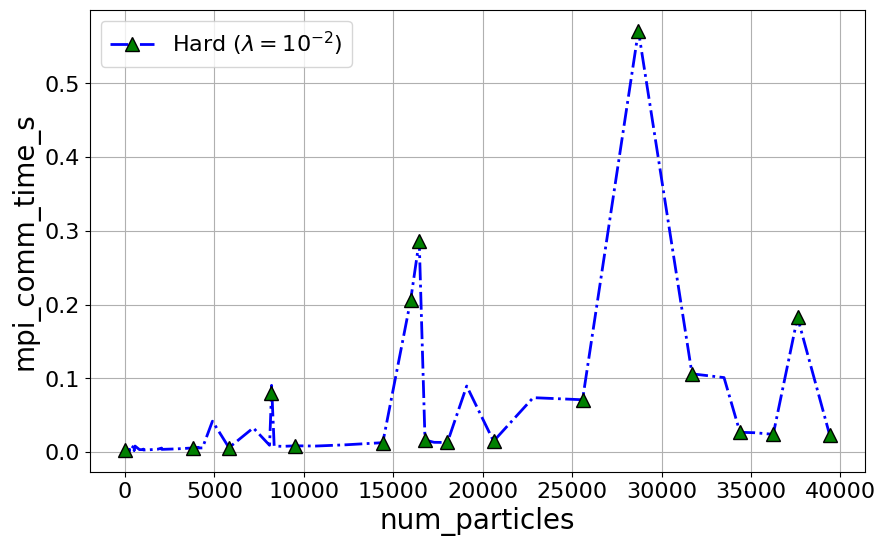

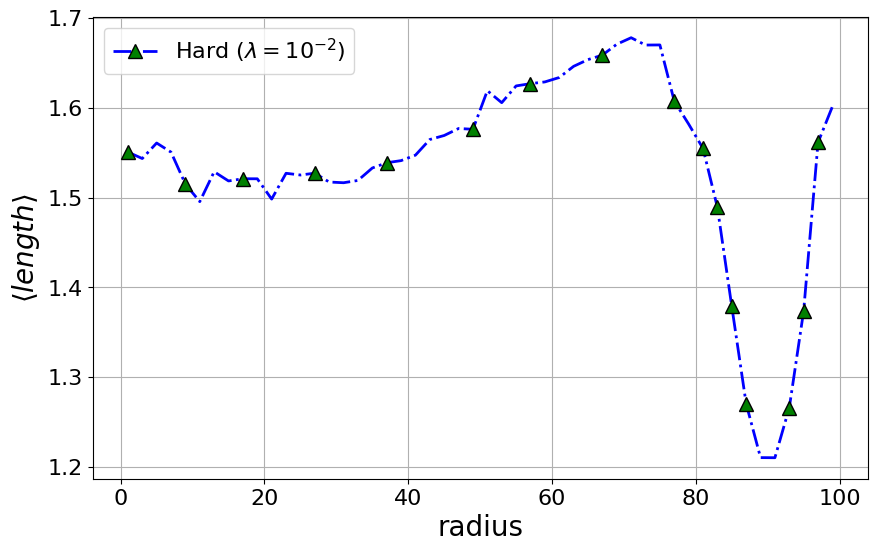

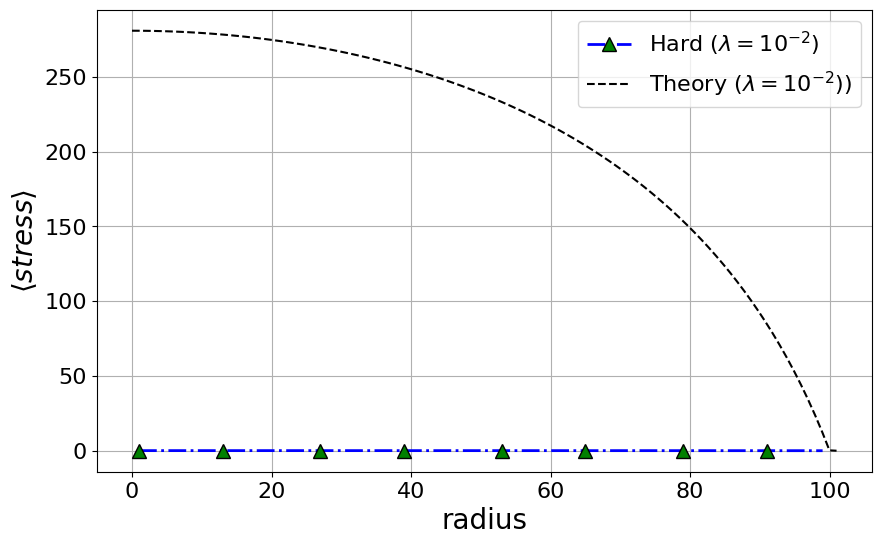

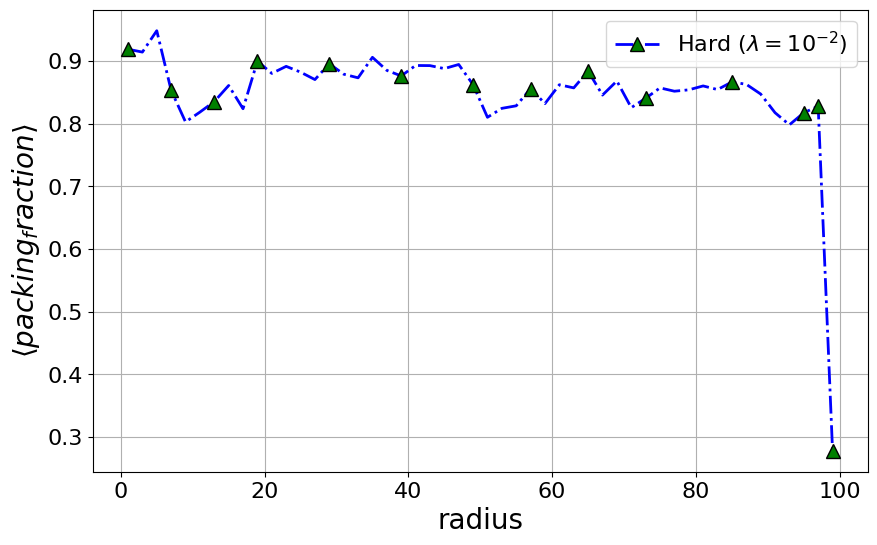

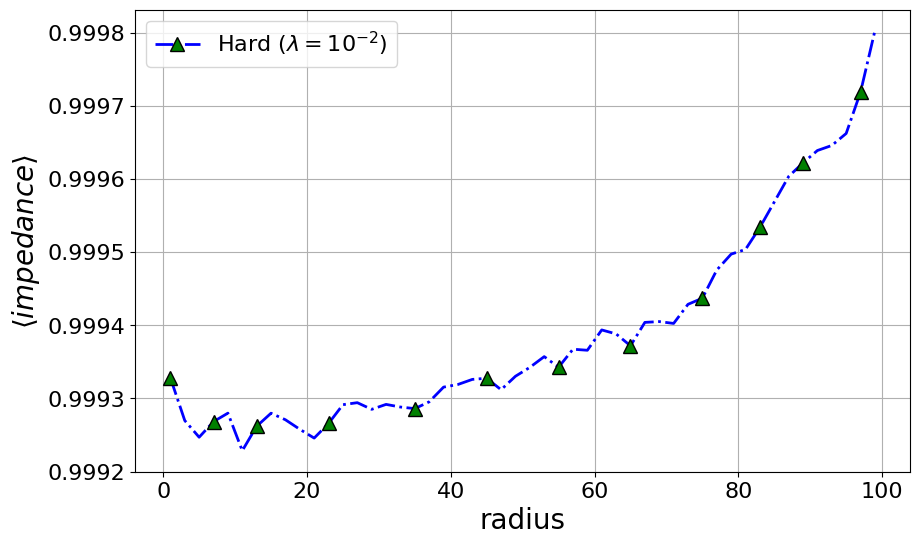

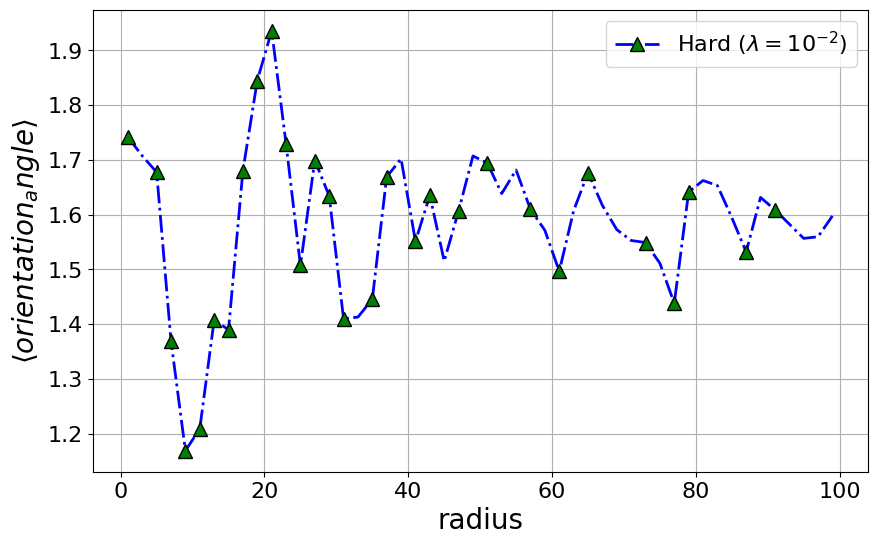

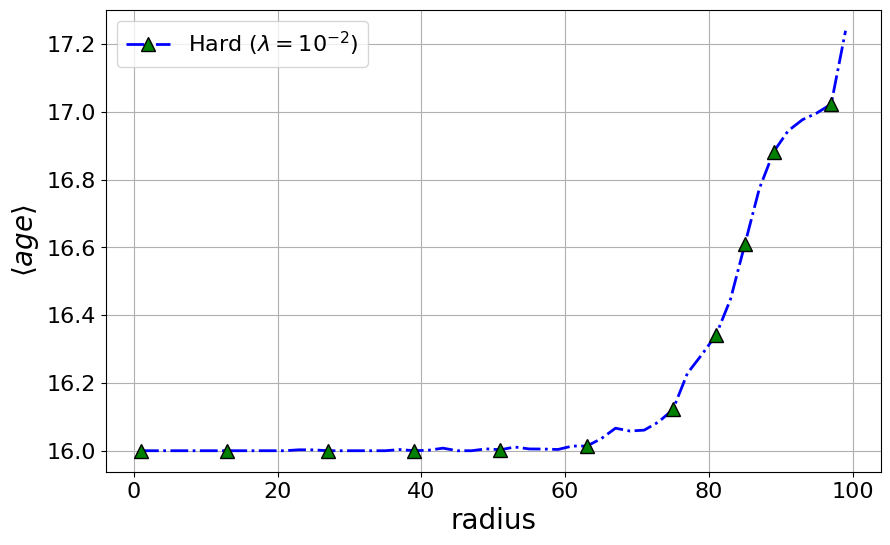

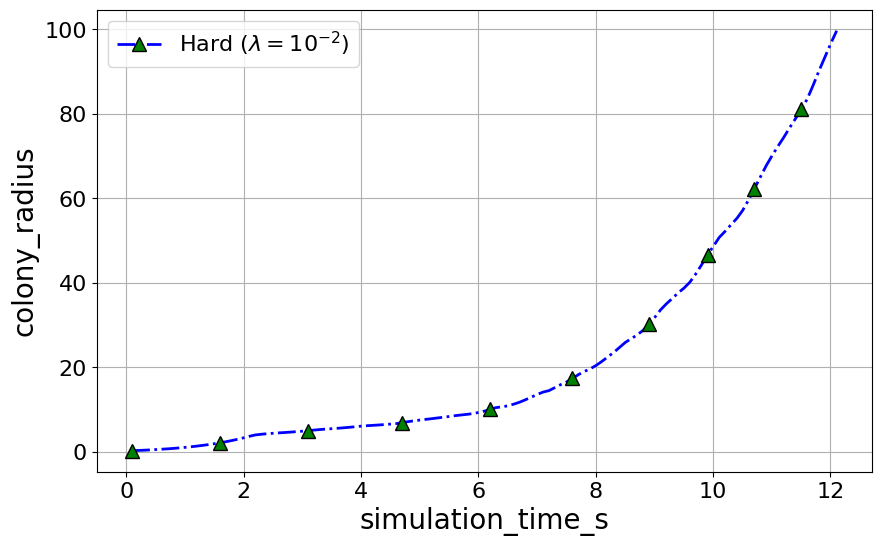

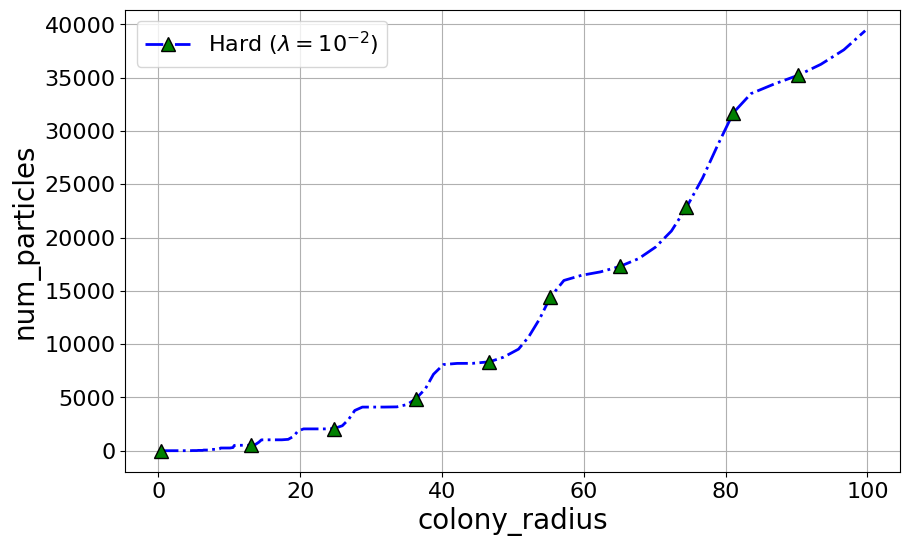

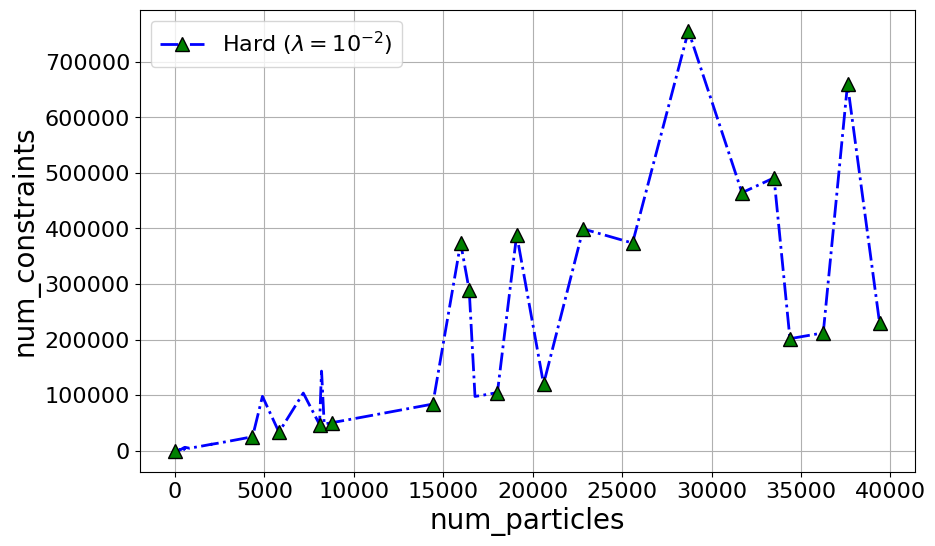

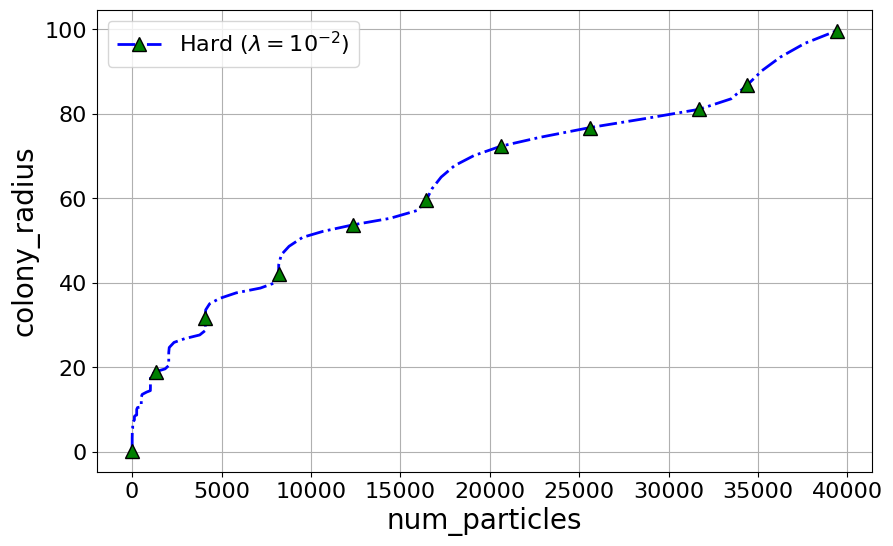

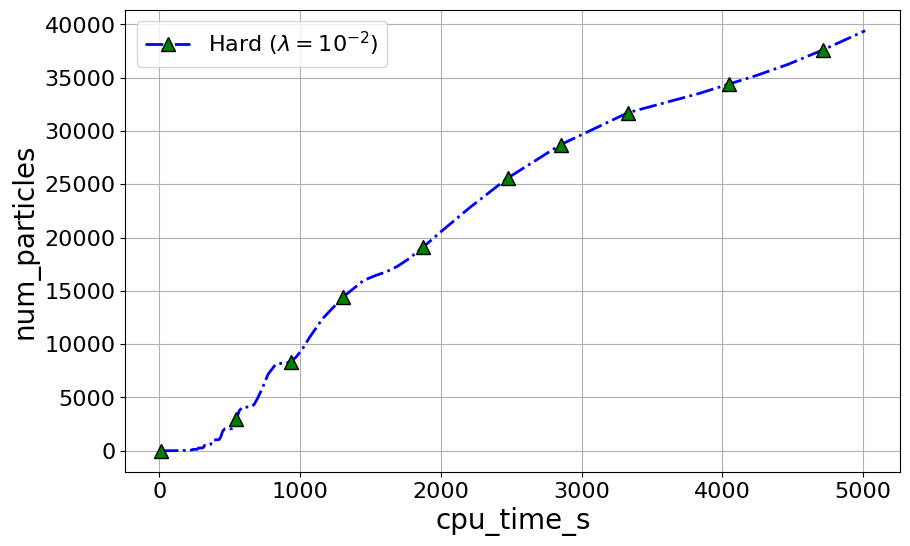

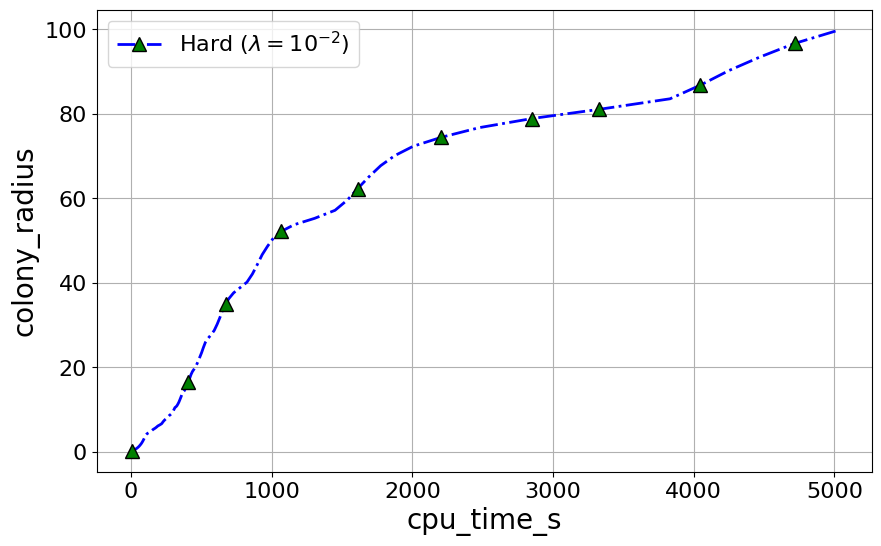

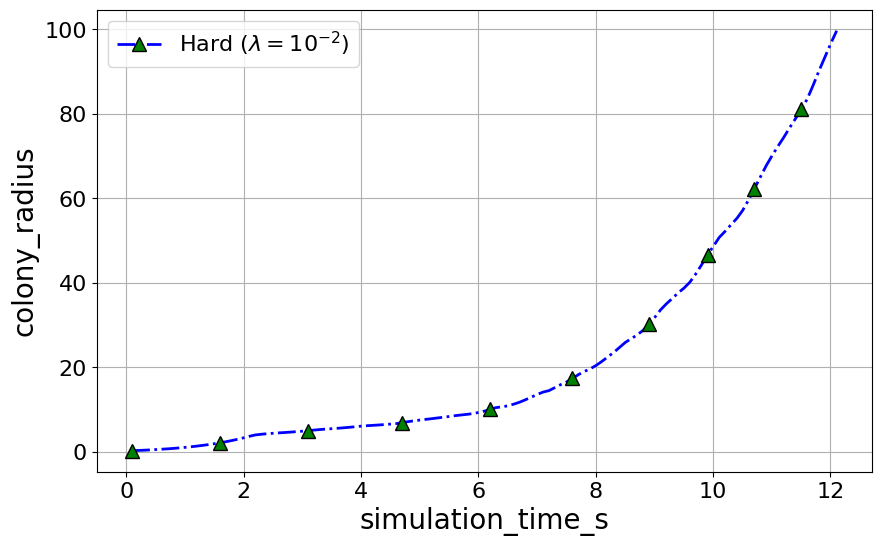

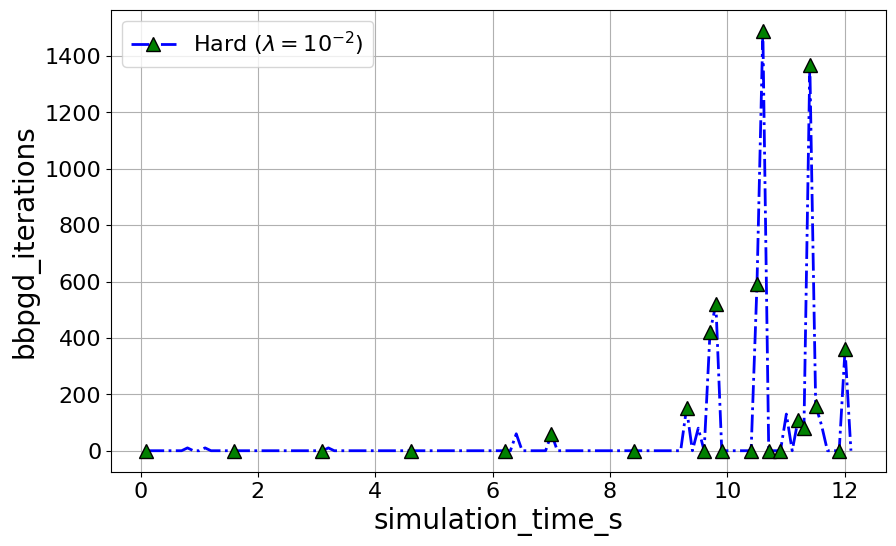

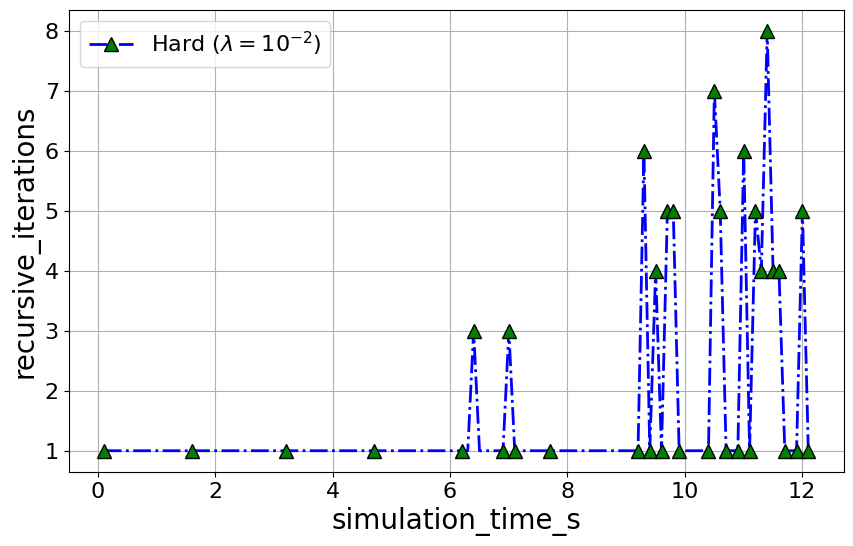

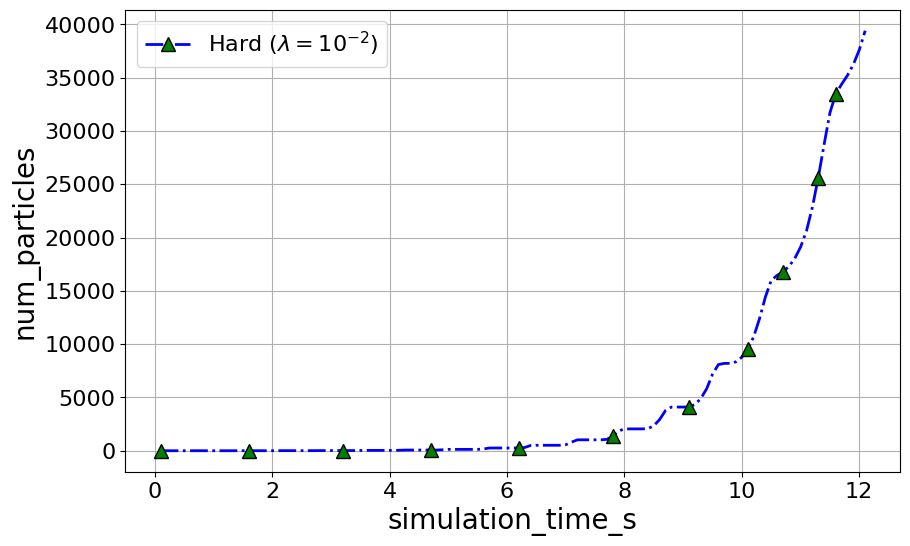

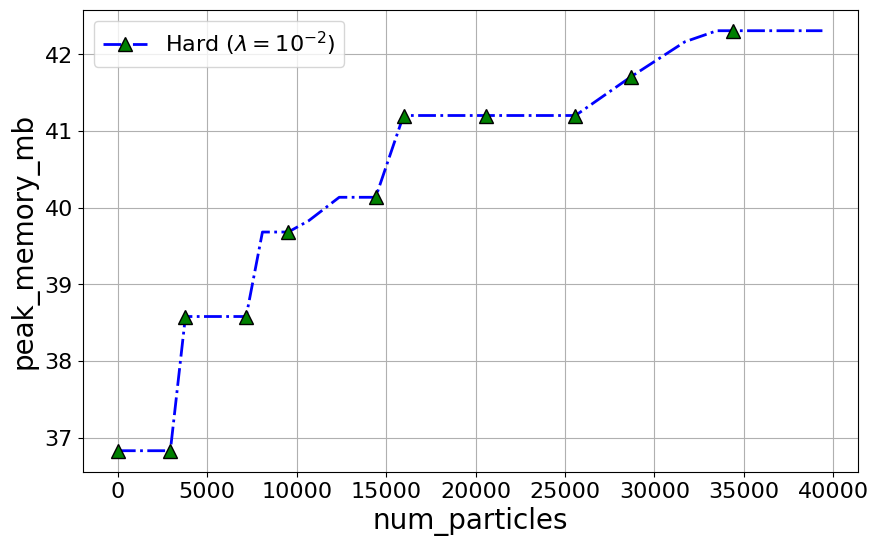

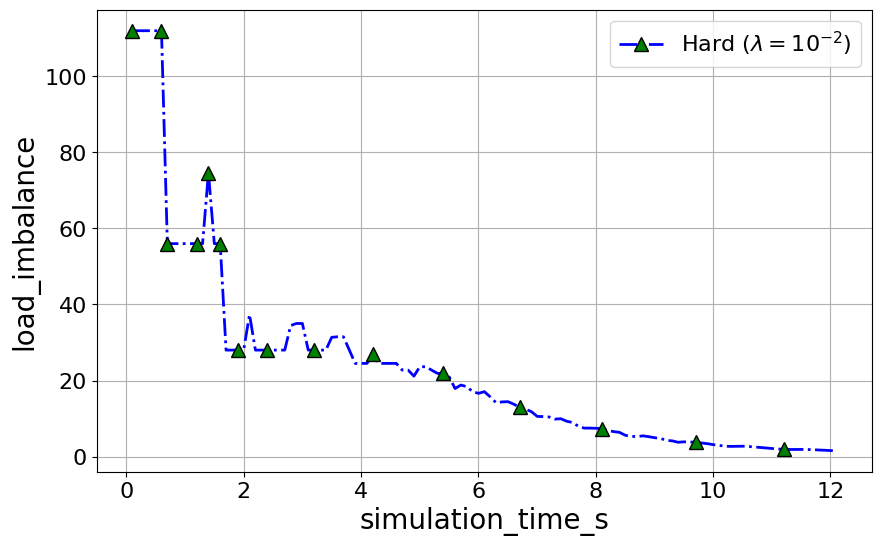

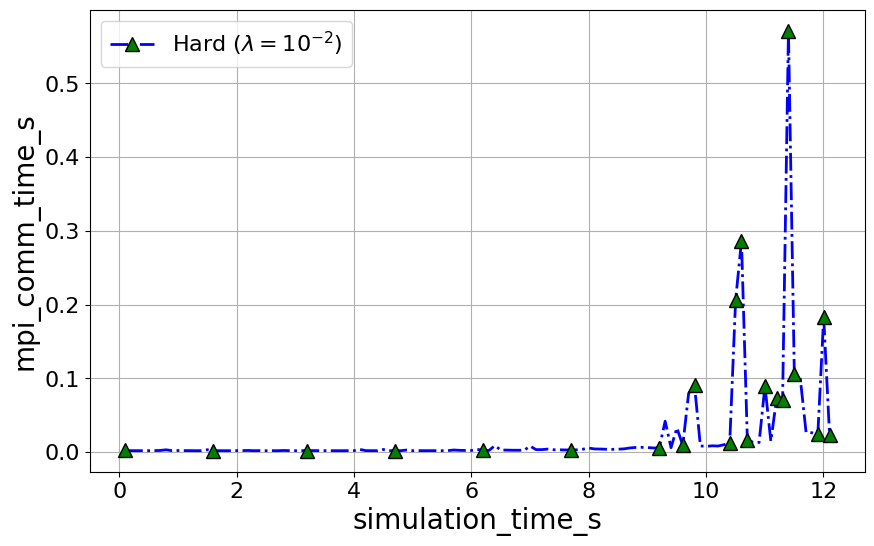

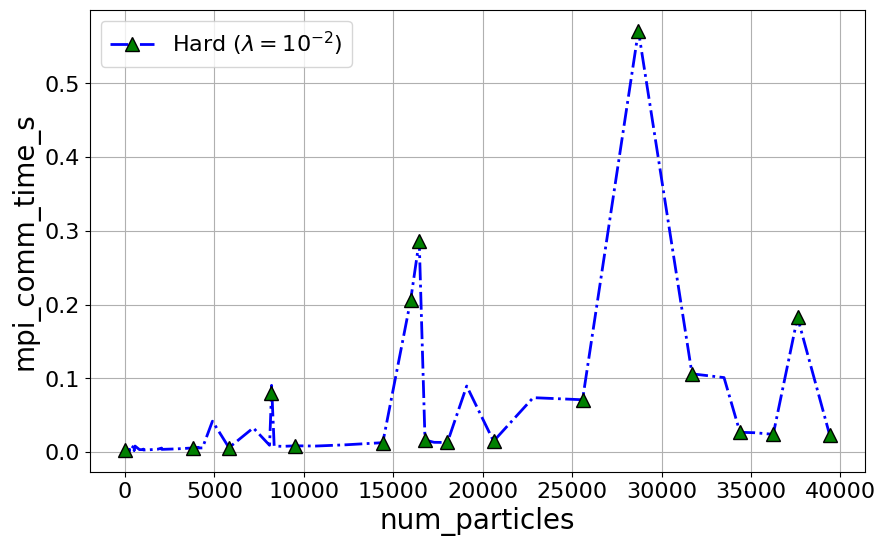

In [39]:

bin_size = 2.0

# Example combined plots
plot_radial_distribution(particles_dict, "length",
                         bin_size)
plot_radial_distribution(particles_dict, "stress",
                         bin_size, plot_theory=True)
plot_radial_distribution(particles_dict, "packing_fraction", bin_size)
plot_radial_distribution(particles_dict, "impedance", bin_size)
plot_radial_distribution(particles_dict, "orientation_angle", bin_size)
plot_radial_distribution(particles_dict, "age", bin_size)


plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "colony_radius")
plot_parameter_over_time(sim_dict, "colony_radius",
                         "num_particles")
plot_parameter_over_time(sim_dict, "num_particles",
                         "num_constraints")
plot_parameter_over_time(sim_dict, "num_particles",
                         "colony_radius")
plot_parameter_over_time(sim_dict, "cpu_time_s",
                         "num_particles")
plot_parameter_over_time(sim_dict, "cpu_time_s",
                         "colony_radius")
plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "colony_radius")
plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "bbpgd_iterations")
plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "recursive_iterations")
plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "num_particles")
plot_parameter_over_time(sim_dict, "num_particles",
                         "peak_memory_mb")

plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "load_imbalance")

plot_parameter_over_time(sim_dict, "simulation_time_s",
                         "mpi_comm_time_s")
plot_parameter_over_time(sim_dict, "num_particles",
                         "mpi_comm_time_s")

In [40]:
# import seaborn as sns

# for key in sim_dict:
#     swarm_plot = sns.pairplot(sim_dict[key])
#     fig = swarm_plot.fig
#     fig.savefig(f"pairplot_sim_{key[0]}_{key[1]}.png", dpi=300, bbox_inches="tight")

# for key in particles_dict:
#     swarm_plot = sns.pairplot(particles_dict[key])
#     fig = swarm_plot.fig
#     fig.savefig(f"pairplot_particles_{key[0]}_{key[1]}.png", dpi=300, bbox_inches="tight")